In [106]:
import cv2
import mediapipe as mp
import numpy as np

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

In [107]:
import glob

jab_color_files = [file for file in glob.glob('./numpy_data_arrays/jab/*color.npz')]
cross_color_files = [file for file in glob.glob('./numpy_data_arrays/cross/*color.npz')]
left_hook_color_files = [file for file in glob.glob('./numpy_data_arrays/left_hook/*color.npz')]
right_hook_color_files = [file for file in glob.glob('./numpy_data_arrays/right_hook/*color.npz')]
random_color_files = [file for file in glob.glob('./numpy_data_arrays/random/*color.npz')]

In [108]:
# Extract 6 frames evenly spread out
def extract_frames(frames):
    extracted_frames = []
    for i in range(1, 7):
        frame_to_extract = (i * (frames.shape[0]) // 6 ) - 1
        extracted_frames.append(frames[frame_to_extract])
    return np.array(extracted_frames)

In [109]:
def get_landmarks(frames):
    landmarks_coords = []

    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        for frame in frames:
            image = cv2.cvtColor(frame, cv2.COLOR_BGRA2RGB)
            image.flags.writeable = False

            pose_results = pose.process(image)

            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            try:
                landmarks = pose_results.pose_landmarks.landmark
                # print (landmarks)
                landmarks_coords.append([[landmark.x, landmark.y] for landmark in landmarks])

            except:
                pass
        return np.array(landmarks_coords).ravel()

In [133]:
X = []
y = []

for file in jab_color_files:
    load_data = np.load(file)
    color_data = load_data['arr_0']
    frames = extract_frames(color_data)
    landmarks = get_landmarks(frames)
    X.append(landmarks)
    y.append('jab')

for file in cross_color_files:
    load_data = np.load(file)
    color_data = load_data['arr_0']
    frames = extract_frames(color_data)
    landmarks = get_landmarks(frames)
    X.append(landmarks)
    y.append('cross')

for file in left_hook_color_files:
    load_data = np.load(file)
    color_data = load_data['arr_0']
    frames = extract_frames(color_data)
    landmarks = get_landmarks(frames)
    X.append(landmarks)
    y.append('left_hook')

for file in right_hook_color_files:
    load_data = np.load(file)
    color_data = load_data['arr_0']
    frames = extract_frames(color_data)
    landmarks = get_landmarks(frames)
    X.append(landmarks)
    y.append('right_hook')

# for file in random_color_files:
#     load_data = np.load(file)
#     color_data = load_data['arr_0']
#     frames = extract_frames(color_data)
#     landmarks = get_landmarks(frames)
#     X.append(landmarks)
#     y.append('random')

In [152]:
from sklearn.model_selection import train_test_split
X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=21)

In [135]:
X_train.shape

(20, 396)

In [136]:
X_test.shape

(80, 396)

In [147]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict

def run_kfolds(model, x, y, splits):
    kf = KFold(n_splits=splits, shuffle=True)
    scores = cross_val_score(model, x, y, cv=kf, scoring="accuracy")
    predict = cross_val_predict(model, X, y, cv=kf)
    return scores, predict

Accuracy: 0.95
SVM Classification Report:
              precision    recall  f1-score   support

       cross       1.00      0.95      0.97        20
         jab       0.95      0.90      0.93        21
   left_hook       0.90      0.95      0.92        19
  right_hook       0.95      1.00      0.98        20

    accuracy                           0.95        80
   macro avg       0.95      0.95      0.95        80
weighted avg       0.95      0.95      0.95        80



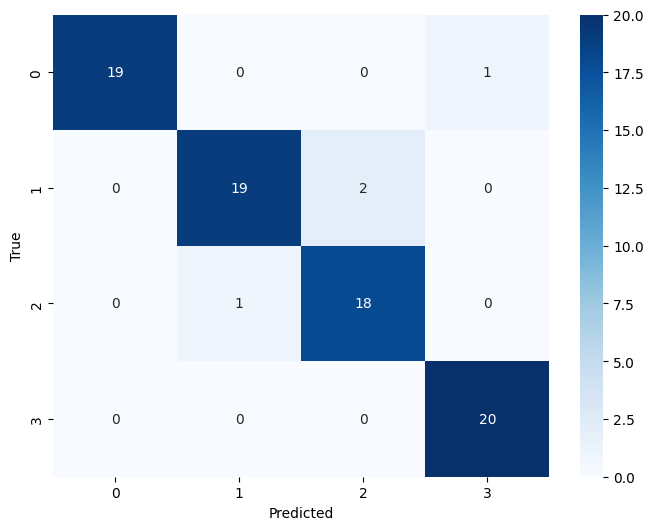

In [138]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

SVM = SVC(kernel='linear')

SVM.fit(X_train, y_train)
y_pred = SVM.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
svm_report = classification_report(y_test, y_pred)

# Display the evaluation metrics
print("Accuracy:", accuracy)
print("SVM Classification Report:")
print(svm_report)

cm = confusion_matrix(y_test, y_pred)
# Get the class labels from LabelEncoder
# class_labels = label_encoder.classes_

# Display the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Accuracy: 0.99
Naive-Bayes Cross-Validation Classification Report:
              precision    recall  f1-score   support

       cross       1.00      1.00      1.00        25
         jab       0.96      1.00      0.98        25
   left_hook       1.00      0.96      0.98        25
  right_hook       1.00      1.00      1.00        25

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



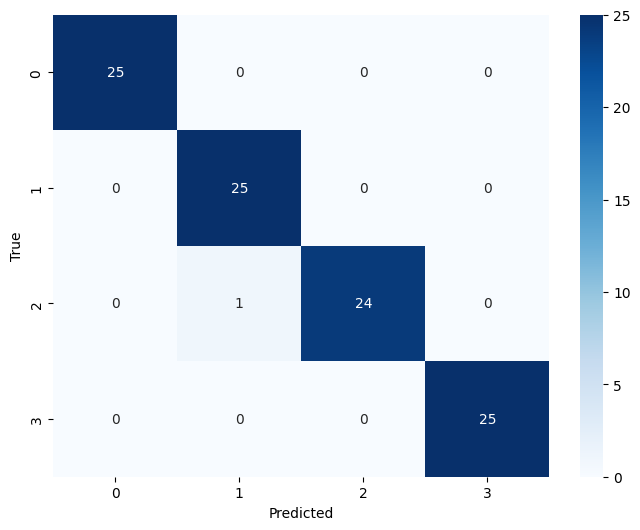

In [148]:
scores, predicts = run_kfolds(SVM, X, y, 5)

# Calculate evaluation metrics
accuracy = accuracy_score(y, predicts)
svm_report = classification_report(y, predicts)

# Display the evaluation metrics
print("Accuracy:", accuracy)
print("Naive-Bayes Cross-Validation Classification Report:")
print(svm_report)

cm = confusion_matrix(y, predicts)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [140]:
# landmarks[0].x

In [141]:
# with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
#     for frame in color_data:
#         image = cv2.cvtColor(frame, cv2.COLOR_BGRA2RGB)
#         image.flags.writeable = False
#         cv2.imshow("IMAGE DETECTIONS", image)

#         pose_results = pose.process(image)

#         image.flags.writeable = True
#         image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

#         mp_drawing.draw_landmarks(image, pose_results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
#                                   mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
#                                   mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2)
#                                   )
#         cv2.imshow("MEDIAPIPE DETECTIONS", image)
        
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()


In [142]:
# with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
#     for frame in color_data:
#         image = cv2.cvtColor(frame, cv2.COLOR_BGRA2RGB)
#         image.flags.writeable = False

#         pose_results = pose.process(image)

#         image.flags.writeable = True
#         image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

#         try:
#             landmarks = pose_results.pose_landmarks.landmark
#             print (landmarks)
#         except:
#             pass

#         mp_drawing.draw_landmarks(image, pose_results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
#                                   mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
#                                   mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2)
#                                   )
#         cv2.imshow("MEDIAPIPE DETECTIONS", image)
        
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()


In [143]:
# for landmark in mp_pose.PoseLandmark:
#     print((landmark))

[(e, e.value) for e in mp_pose.PoseLandmark]

[(<PoseLandmark.NOSE: 0>, 0),
 (<PoseLandmark.LEFT_EYE_INNER: 1>, 1),
 (<PoseLandmark.LEFT_EYE: 2>, 2),
 (<PoseLandmark.LEFT_EYE_OUTER: 3>, 3),
 (<PoseLandmark.RIGHT_EYE_INNER: 4>, 4),
 (<PoseLandmark.RIGHT_EYE: 5>, 5),
 (<PoseLandmark.RIGHT_EYE_OUTER: 6>, 6),
 (<PoseLandmark.LEFT_EAR: 7>, 7),
 (<PoseLandmark.RIGHT_EAR: 8>, 8),
 (<PoseLandmark.MOUTH_LEFT: 9>, 9),
 (<PoseLandmark.MOUTH_RIGHT: 10>, 10),
 (<PoseLandmark.LEFT_SHOULDER: 11>, 11),
 (<PoseLandmark.RIGHT_SHOULDER: 12>, 12),
 (<PoseLandmark.LEFT_ELBOW: 13>, 13),
 (<PoseLandmark.RIGHT_ELBOW: 14>, 14),
 (<PoseLandmark.LEFT_WRIST: 15>, 15),
 (<PoseLandmark.RIGHT_WRIST: 16>, 16),
 (<PoseLandmark.LEFT_PINKY: 17>, 17),
 (<PoseLandmark.RIGHT_PINKY: 18>, 18),
 (<PoseLandmark.LEFT_INDEX: 19>, 19),
 (<PoseLandmark.RIGHT_INDEX: 20>, 20),
 (<PoseLandmark.LEFT_THUMB: 21>, 21),
 (<PoseLandmark.RIGHT_THUMB: 22>, 22),
 (<PoseLandmark.LEFT_HIP: 23>, 23),
 (<PoseLandmark.RIGHT_HIP: 24>, 24),
 (<PoseLandmark.LEFT_KNEE: 25>, 25),
 (<PoseLandmark.R

vstack
shape:
num_frames x num_landmarks x 2

ravel
train = num_train_samples x num_frames x num_landmarks x 2
test = num_test_samples x num_frames x num_landmarks x 2

Data augmentation, mirror

K_folds show results for one fold

Iterations vs Accuracy


Accuracy: 0.975
mlp Classification Report:
              precision    recall  f1-score   support

       cross       0.95      0.95      0.95        21
         jab       1.00      1.00      1.00        22
   left_hook       1.00      1.00      1.00        17
  right_hook       0.95      0.95      0.95        20

    accuracy                           0.97        80
   macro avg       0.98      0.98      0.98        80
weighted avg       0.97      0.97      0.97        80



C:\Users\alvie\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


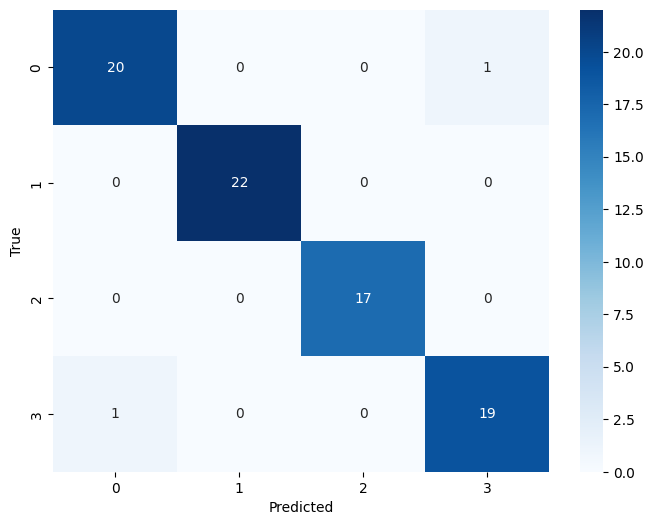

In [162]:
#import the classifier
from sklearn.neural_network import MLPClassifier

# initialize the classifier
#MLP = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
MLP = MLPClassifier(max_iter=150)

MLP.fit(X_train, y_train)
y_pred = MLP.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
mlp_report = classification_report(y_test, y_pred)

# Display the evaluation metrics
print("Accuracy:", accuracy)
print("mlp Classification Report:")
print(mlp_report)

cm = confusion_matrix(y_test, y_pred)
# Get the class labels from LabelEncoder
# class_labels = label_encoder.classes_

# Display the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Accuracy: 0.7
mlp Classification Report:
              precision    recall  f1-score   support

       cross       0.84      0.76      0.80        21
         jab       0.88      0.32      0.47        22
   left_hook       0.53      0.94      0.68        17
  right_hook       0.74      0.85      0.79        20

    accuracy                           0.70        80
   macro avg       0.75      0.72      0.68        80
weighted avg       0.76      0.70      0.68        80



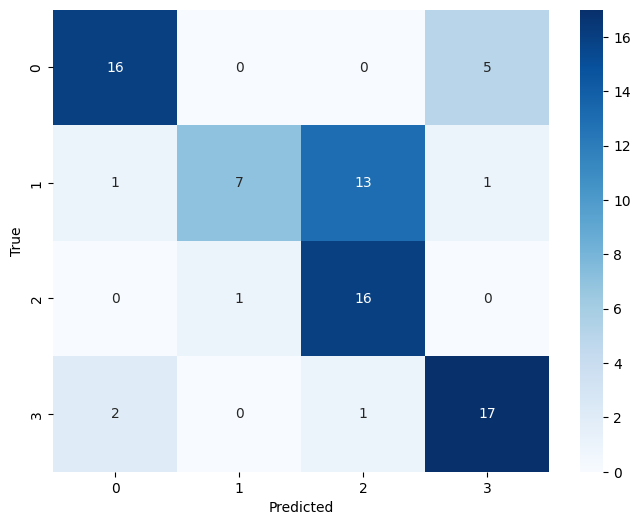

In [163]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
mlp_report = classification_report(y_test, y_pred)

# Display the evaluation metrics
print("Accuracy:", accuracy)
print("mlp Classification Report:")
print(mlp_report)

cm = confusion_matrix(y_test, y_pred)
# Get the class labels from LabelEncoder
# class_labels = label_encoder.classes_

# Display the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()